In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_XCRD
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [7]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_XCRD
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 340

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 20

data w_diffuse
     &     /1.6 , 1.8 , 1.8 , 1.8,
     &     1.7 , 1.6 , 1.4 , 1.4,
     &     1.7 , 1.8/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/saw75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database',)).History will not be written to the database.


In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

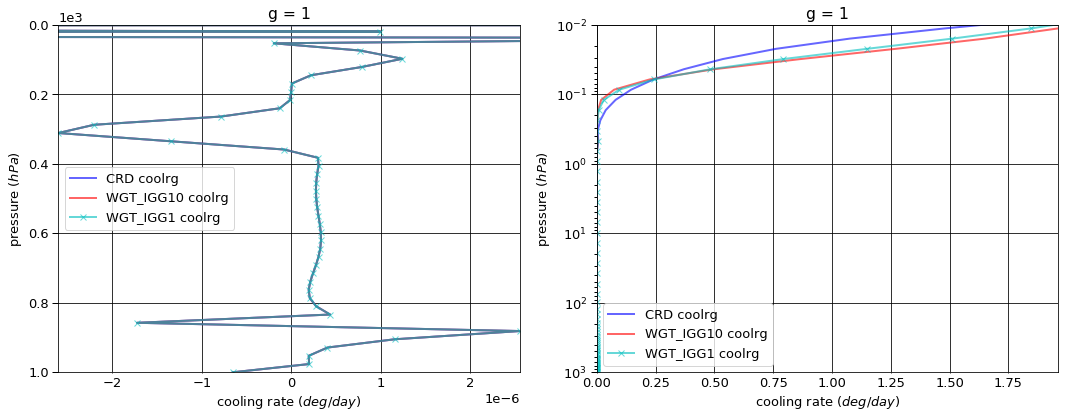

# Figure: cooling rate g-group 2

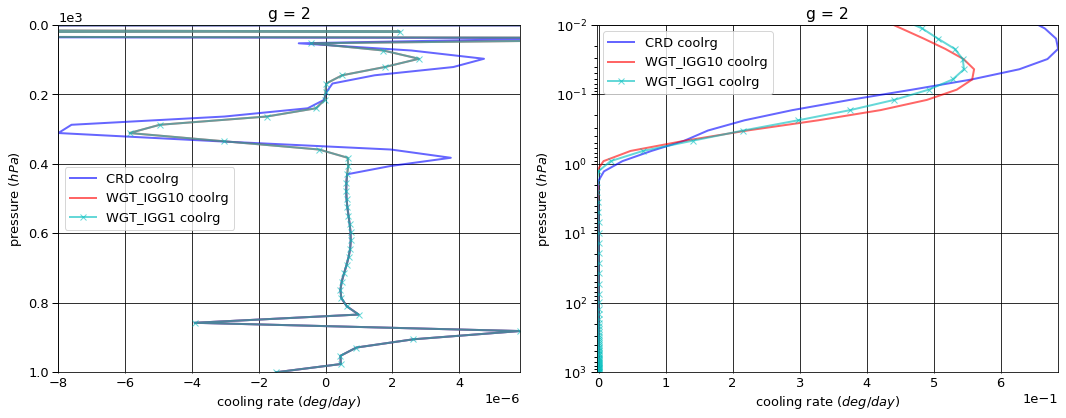

# Figure: cooling rate g-group 3

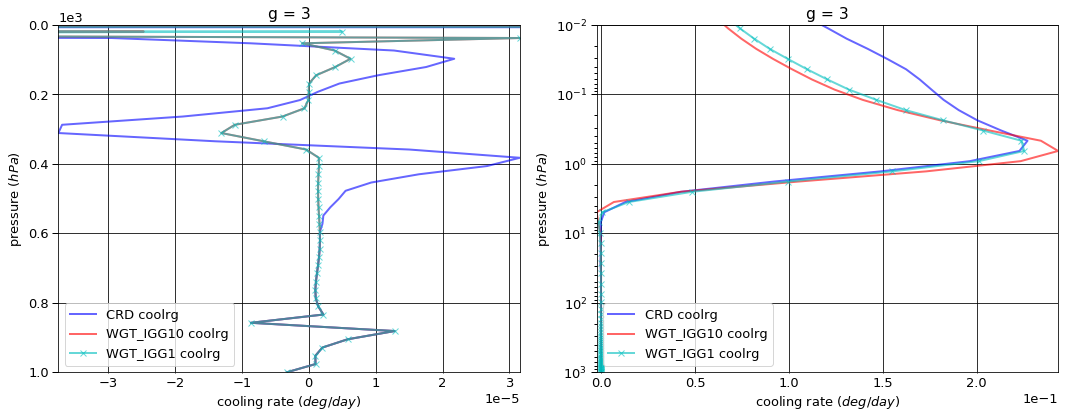

# Figure: cooling rate g-group 4

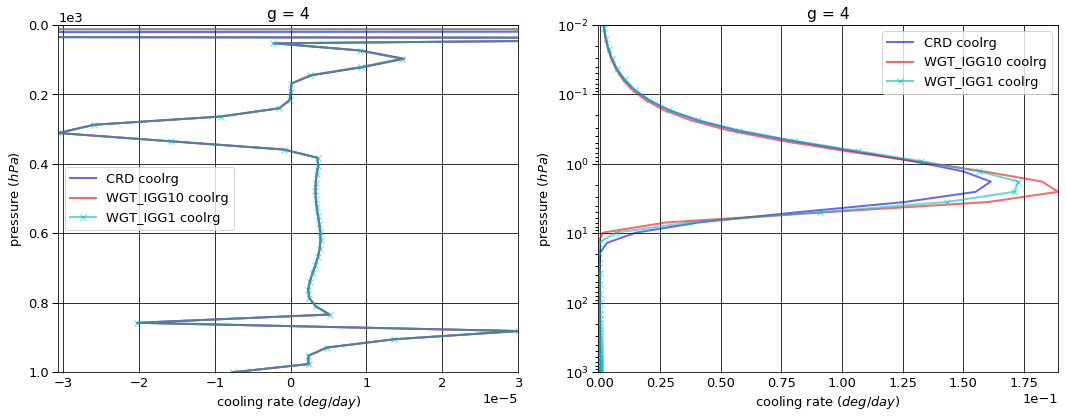

# Figure: cooling rate g-group 5

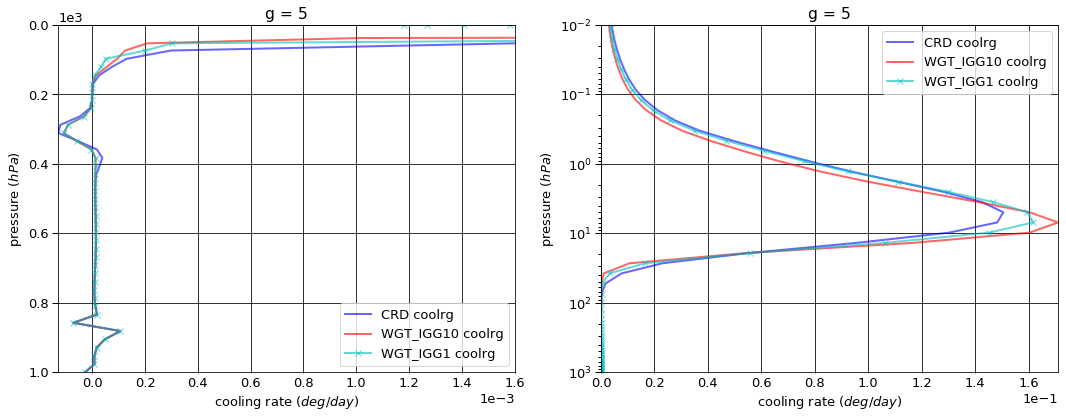

# Figure: cooling rate g-group 6

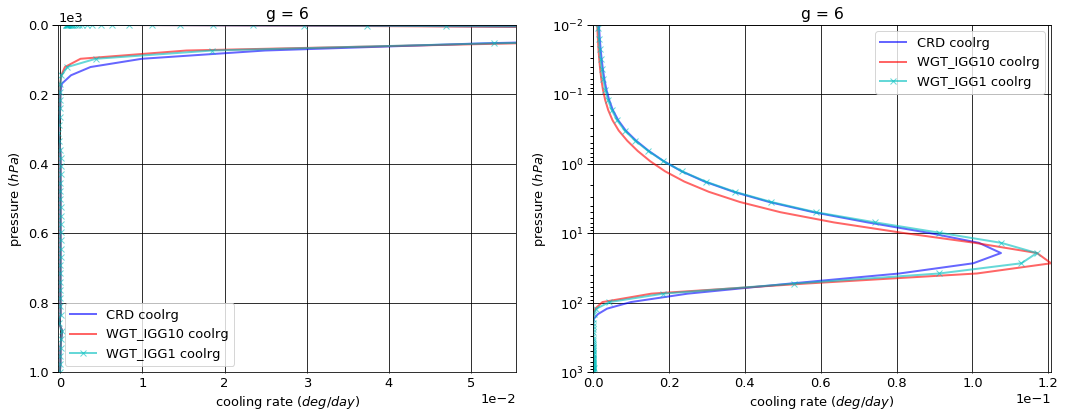

# Figure: cooling rate g-group 7

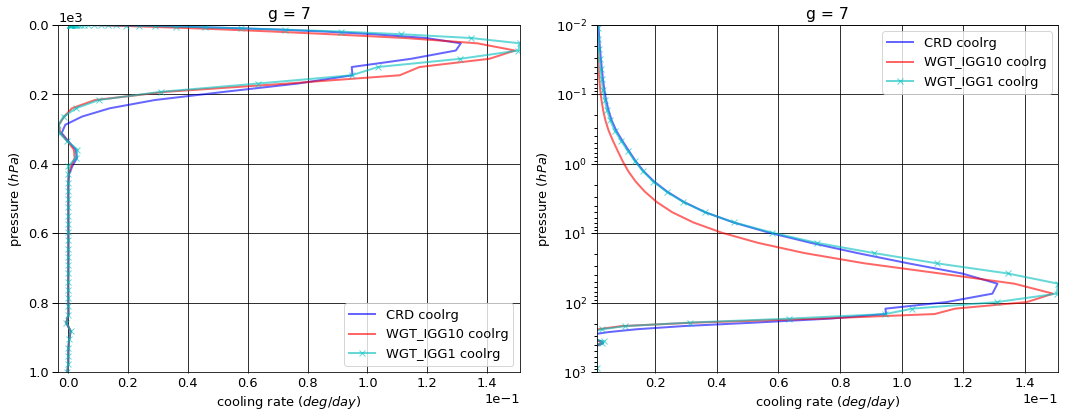

# Figure: cooling rate g-group 8

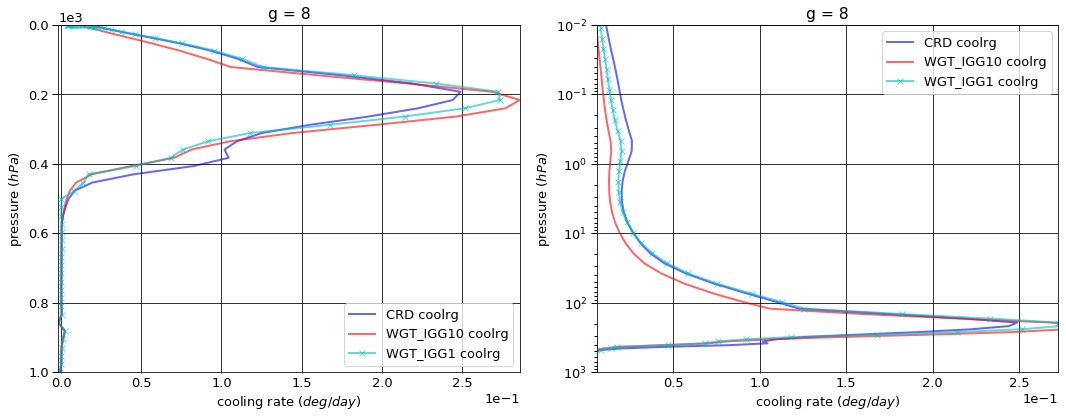

# Figure: cooling rate g-group 9

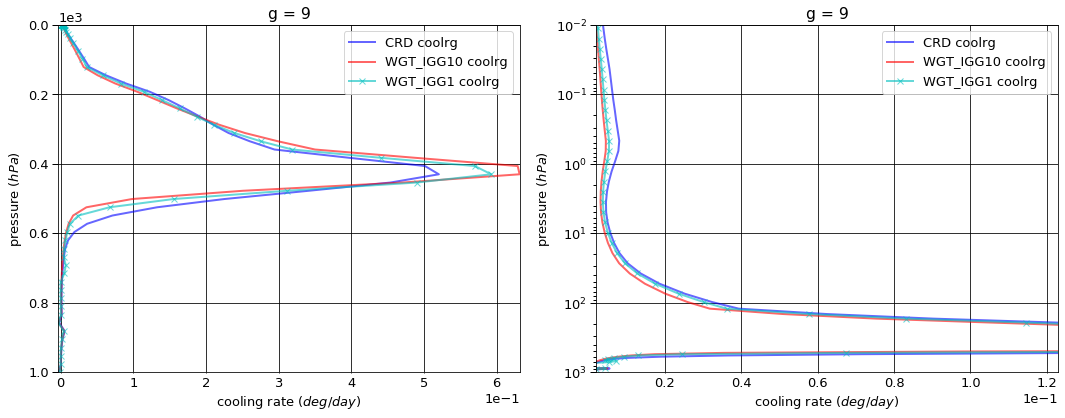

# Figure: cooling rate g-group 10

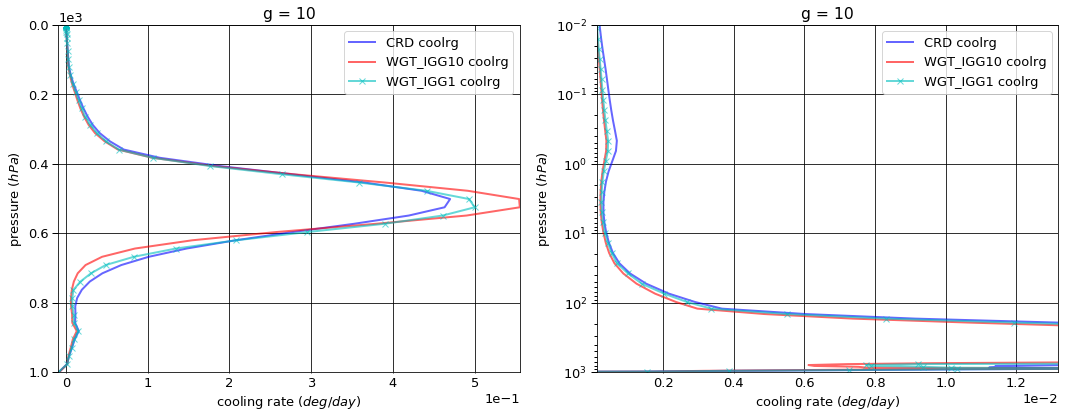

# Figure: cooling rate g-group total

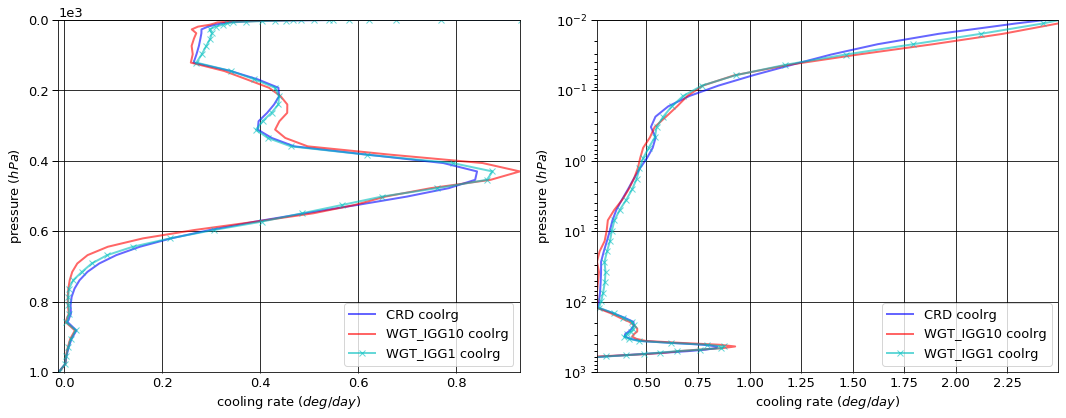

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.008384   0.000000  -0.008384
   1013.0   76     -0.009922   0.009924   0.000002
2  0.0      1      -0.020374   0.000000  -0.020374
   1013.0   76     -0.021534   0.021539   0.000005
3  0.0      1      -0.045982   0.000000  -0.045982
   1013.0   76     -0.049817   0.049829   0.000011
4  0.0      1      -0.097483   0.000000  -0.097483
   1013.0   76     -0.118087   0.118113   0.000026
5  0.0      1      -0.308548   0.000000  -0.308548
   1013.0   76     -0.412195   0.412289   0.000093
6  0.0      1      -0.668654   0.000000  -0.668654
   1013.0   76     -0.921652   0.921857   0.000205
7  0.0      1      -2.460107   0.000000  -2.460107
   1013.0   76     -3.378237   3.379004   0.000767
8  0.0      1      -7.104642   0.000000  -7.104642
   1013.0   76     -9.575829   9.578019   0.002190
9  0.0      1     -13.098027   0.000000 -13.098027
   1013.0   76    -16.645150  16.652543   0.007392
10 0.0      1     -12.242415   0.000000 -12.242415
   1013.0   76    -14.391668  14.431775   0.040107


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.008434   0.000000  -0.008434
   1013.0   76     -0.009922   0.009924   0.000002
2  0.0      1      -0.020589   0.000000  -0.020589
   1013.0   76     -0.021534   0.021539   0.000005
3  0.0      1      -0.046423   0.000000  -0.046423
   1013.0   76     -0.049817   0.049829   0.000011
4  0.0      1      -0.098623   0.000000  -0.098623
   1013.0   76     -0.118087   0.118113   0.000026
5  0.0      1      -0.308973   0.000000  -0.308973
   1013.0   76     -0.412195   0.412289   0.000093
6  0.0      1      -0.666141   0.000000  -0.666141
   1013.0   76     -0.921652   0.921857   0.000205
7  0.0      1      -2.459307   0.000000  -2.459307
   1013.0   76     -3.378237   3.379004   0.000767
8  0.0      1      -7.067122   0.000000  -7.067122
   1013.0   76     -9.575829   9.578012   0.002183
9  0.0      1     -12.965350   0.000000 -12.965350
   1013.0   76    -16.645150  16.650737   0.005587
10 0.0      1     -12.172273   0.000000 -12.172273
   1013.0   76    -14.391668  14.424059   0.032391


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.008419   0.000000  -0.008419
   1013.0   76     -0.009922   0.009924   0.000002
2  0.0      1      -0.020598   0.000000  -0.020598
   1013.0   76     -0.021534   0.021539   0.000005
3  0.0      1      -0.046035   0.000000  -0.046035
   1013.0   76     -0.049817   0.049829   0.000011
4  0.0      1      -0.098200   0.000000  -0.098200
   1013.0   76     -0.118087   0.118113   0.000026
5  0.0      1      -0.309211   0.000000  -0.309211
   1013.0   76     -0.412195   0.412289   0.000093
6  0.0      1      -0.667413   0.000000  -0.667413
   1013.0   76     -0.921652   0.921857   0.000205
7  0.0      1      -2.456138   0.000000  -2.456138
   1013.0   76     -3.378237   3.379004   0.000767
8  0.0      1      -7.061854   0.000000  -7.061854
   1013.0   76     -9.575829   9.578012   0.002183
9  0.0      1     -13.004977   0.000000 -13.004977
   1013.0   76    -16.645150  16.649111   0.003961
10 0.0      1     -12.232604   0.000000 -12.232604
   1013.0   76    -14.391668  14.431123   0.039455


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                      
1  0.0      1     -0.000050  0.000000e+00 -4.973110e-05
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
2  0.0      1     -0.000215  0.000000e+00 -2.151300e-04
   1013.0   76     0.000000 -3.469447e-18  0.000000e+00
3  0.0      1     -0.000441  0.000000e+00 -4.410870e-04
   1013.0   76     0.000000 -6.938894e-18  0.000000e+00
4  0.0      1     -0.001140  0.000000e+00 -1.140492e-03
   1013.0   76     0.000000  0.000000e+00  3.388132e-21
5  0.0      1     -0.000426  0.000000e+00 -4.255600e-04
   1013.0   76     0.000000  0.000000e+00  1.355253e-20
6  0.0      1      0.002513  0.000000e+00  2.512930e-03
   1013.0   76     0.000000  0.000000e+00  2.710505e-20
7  0.0      1      0.000800  0.000000e+00  7.998000e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
8  0.0      1      0.037520  0.000000e+00  3.751980e-02
   1013.0   76     0.000000 -6.900000e-06 -6.933500e-06
9  0.0      1      0.132677  0.000000e+00  1.326770e-01
   1013.0   76     0.000000 -1.806000e-03 -1.805476e-03
10 0.0      1      0.070142  0.000000e+00  7.014200e-02
   1013.0   76     0.000000 -7.716000e-03 -7.716085e-03


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                      
1  0.0      1     -0.000035  0.000000e+00 -3.512760e-05
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
2  0.0      1     -0.000224  0.000000e+00 -2.241480e-04
   1013.0   76     0.000000 -3.469447e-18  0.000000e+00
3  0.0      1     -0.000053  0.000000e+00 -5.314500e-05
   1013.0   76     0.000000 -6.938894e-18  0.000000e+00
4  0.0      1     -0.000717  0.000000e+00 -7.168840e-04
   1013.0   76     0.000000  0.000000e+00  3.388132e-21
5  0.0      1     -0.000663  0.000000e+00 -6.628800e-04
   1013.0   76     0.000000  0.000000e+00  1.355253e-20
6  0.0      1      0.001241  0.000000e+00  1.241350e-03
   1013.0   76     0.000000  0.000000e+00  2.710505e-20
7  0.0      1      0.003969  0.000000e+00  3.969200e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
8  0.0      1      0.042788  0.000000e+00  4.278800e-02
   1013.0   76     0.000000 -6.900000e-06 -6.933500e-06
9  0.0      1      0.093050  0.000000e+00  9.305000e-02
   1013.0   76     0.000000 -3.432000e-03 -3.431617e-03
10 0.0      1      0.009811  0.000000e+00  9.811000e-03
   1013.0   76     0.000000 -6.520000e-04 -6.517920e-04

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      4.319128e+00
   1001.112500 75    -6.528382e-07
2  0.000312    1      3.306119e-01
   1001.112500 75    -1.484573e-06
3  0.000312    1      5.377701e-02
   1001.112500 75    -3.279223e-06
4  0.000312    1      9.258738e-05
   1001.112500 75    -7.677849e-06
5  0.000312    1      1.352357e-03
   1001.112500 75    -2.712366e-05
6  0.000312    1      7.028442e-04
   1001.112500 75    -5.958928e-05
7  0.000312    1      6.135308e-04
   1001.112500 75    -2.227821e-04
8  0.000312    1      5.132518e-03
   1001.112500 75    -6.357027e-04
9  0.000312    1      1.889903e-03
   1001.112500 75    -2.111955e-03
10 0.000312    1      5.564371e-05
   1001.112500 75    -8.787606e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      2.026346e+00
   1001.112500 75    -6.528382e-07
2  0.000312    1      1.978579e-01
   1001.112500 75    -1.484573e-06
3  0.000312    1      2.981645e-02
   1001.112500 75    -3.279223e-06
4  0.000312    1      1.024550e-04
   1001.112500 75    -7.677849e-06
5  0.000312    1      1.039836e-03
   1001.112500 75    -2.712366e-05
6  0.000312    1      5.581670e-04
   1001.112500 75    -5.958928e-05
7  0.000312    1      3.565744e-04
   1001.112500 75    -2.227821e-04
8  0.000312    1      2.738324e-03
   1001.112500 75    -6.340475e-04
9  0.000312    1      1.024700e-03
   1001.112500 75    -1.610375e-03
10 0.000312    1      3.057628e-05
   1001.112500 75    -8.320423e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      2.537117e+00
   1001.112500 75    -6.528382e-07
2  0.000312    1      2.278380e-01
   1001.112500 75    -1.484573e-06
3  0.000312    1      3.254690e-02
   1001.112500 75    -3.279223e-06
4  0.000312    1      1.090202e-04
   1001.112500 75    -7.677849e-06
5  0.000312    1      1.179217e-03
   1001.112500 75    -2.712366e-05
6  0.000312    1      6.863970e-04
   1001.112500 75    -5.958928e-05
7  0.000312    1      5.087375e-04
   1001.112500 75    -2.227821e-04
8  0.000312    1      3.914589e-03
   1001.112500 75    -6.340475e-04
9  0.000312    1      1.223950e-03
   1001.112500 75    -1.150491e-03
10 0.000312    1      3.529969e-05
   1001.112500 75    -9.316570e-03


WGT_IGG10 - CRD


coolrg
g  pressure    layer          
1  0.000312    1     -2.292782
   1001.112500 75     0.000000
2  0.000312    1     -0.132754
   1001.112500 75     0.000000
3  0.000312    1     -0.023961
   1001.112500 75     0.000000
4  0.000312    1      0.000010
   1001.112500 75     0.000000
5  0.000312    1     -0.000313
   1001.112500 75     0.000000
6  0.000312    1     -0.000145
   1001.112500 75     0.000000
7  0.000312    1     -0.000257
   1001.112500 75     0.000000
8  0.000312    1     -0.002394
   1001.112500 75     0.000002
9  0.000312    1     -0.000865
   1001.112500 75     0.000502
10 0.000312    1     -0.000025
   1001.112500 75     0.000467


WGT_IGG1 - CRD


coolrg
g  pressure    layer          
1  0.000312    1     -1.782011
   1001.112500 75     0.000000
2  0.000312    1     -0.102774
   1001.112500 75     0.000000
3  0.000312    1     -0.021230
   1001.112500 75     0.000000
4  0.000312    1      0.000016
   1001.112500 75     0.000000
5  0.000312    1     -0.000173
   1001.112500 75     0.000000
6  0.000312    1     -0.000016
   1001.112500 75     0.000000
7  0.000312    1     -0.000105
   1001.112500 75     0.000000
8  0.000312    1     -0.001218
   1001.112500 75     0.000002
9  0.000312    1     -0.000666
   1001.112500 75     0.000961
10 0.000312    1     -0.000020
   1001.112500 75    -0.000529

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-36.054616,0.000000,-36.054616
1013.0,76,-45.524092,45.574893,0.050800



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-35.813237,0.000000,-35.813237
1013.0,76,-45.524092,45.565364,0.041271



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-35.905449,0.000000,-35.905449
1013.0,76,-45.524092,45.570802,0.046710



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.24138,0.000000,0.241380
1013.0,76,0.00000,-0.009529,-0.009528



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.149167,0.000000,0.149167
1013.0,76,0.000000,-0.004091,-0.004090


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,4.713356
1001.112500,75,-0.011858



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2.259871
1001.112500,75,-0.010887



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.805159
1001.112500,75,-0.011424



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.453485
1001.112500,75,0.000970



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.908197
1001.112500,75,0.000434


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000250,0.000219
2,0.000485,0.000474
3,0.001324,0.001098
4,0.003015,0.002605
5,0.011074,0.009089
6,0.024324,0.020338
7,0.090544,0.074488
8,0.248324,0.211068
9,0.383882,0.366104


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.096164e-16
2,1.309690e-17
3,1.564810e-18
4,4.601703e-18
5,5.682550e-19
6,6.154553e-19
7,7.853808e-20
8,1.002222e-20
9,1.278933e-21


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.096164e-16,NaN,0.000250,0.000219,0.000250,0.000219,1.0
2,1.309690e-17,0.119479,0.000485,0.000474,0.000735,0.000692,1.0
3,1.564810e-18,0.119479,0.001324,0.001098,0.002059,0.001791,1.0
4,4.601703e-18,2.940742,0.003015,0.002605,0.005074,0.004395,30.0
5,5.682550e-19,0.123488,0.011074,0.009089,0.016147,0.013484,30.0
6,6.154553e-19,1.083062,0.024324,0.020338,0.040471,0.033822,300.0
7,7.853808e-20,0.127610,0.090544,0.074488,0.131015,0.108310,300.0
8,1.002222e-20,0.127610,0.248324,0.211068,0.379338,0.319378,300.0
9,1.278933e-21,0.127610,0.383882,0.366104,0.763221,0.685482,300.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     3.522970e-16  1.449404e-16   2.430634  1.764091e-02
      2  0.000312     1.526604e-17  8.714835e-18   1.751730  9.095377e-04
      3  0.000312     1.116110e-18  4.080229e-19   2.735410  5.283816e-05
      4  0.000312     7.378631e-22  7.360304e-22   1.002490  6.272802e-08
      5  0.000312     2.739872e-21  1.666322e-21   1.644263  1.693333e-07
      6  0.000312     5.853422e-22  4.358681e-22   1.342934  4.093784e-08
      7  0.000312     1.294958e-22  5.057841e-23   2.560299  8.339735e-09
      8  0.000312     4.266557e-22  3.592903e-23  11.874958  2.302460e-08
      9  0.000312     8.586102e-23  4.057785e-24  21.159579  4.525440e-09
      10 0.000312     3.515907e-24  3.563462e-25   9.866550  1.917900e-10
2     1  0.000750     3.549857e-16  1.460107e-16   2.431230  7.158891e-03
      2  0.000750     1.562238e-17  8.870165e-18   1.761228  3.737463e-04
      3  0.000750     1.133446e-18  4.170335e-19   2.717878  2.167726e-05
      4  0.000750     1.012336e-21  1.010220e-21   1.002094  3.467412e-08
      5  0.000750     2.834874e-21  1.743691e-21   1.625789  7.104056e-08
      6  0.000750     5.979039e-22  4.446464e-22   1.344673  1.682926e-08
      7  0.000750     1.334051e-22  5.196526e-23   2.567198  3.458620e-09
      8  0.000750     4.341499e-22  3.647626e-23  11.902259  9.435746e-09
      9  0.000750     8.731130e-23  4.130698e-24  21.137176  1.853636e-09
      10 0.000750     3.680358e-24  3.641561e-25  10.106537  8.074216e-11
3     1  0.001052     3.603502e-16  1.480830e-16   2.433434  1.018672e-02
      2  0.001052     1.635282e-17  9.169648e-18   1.783364  5.447622e-04
      3  0.001052     1.168274e-18  4.332268e-19   2.696680  3.144777e-05
      4  0.001052     1.267967e-21  1.265152e-21   1.002225  6.089992e-08
      5  0.001052     2.998477e-21  1.868163e-21   1.605040  1.061786e-07
      6  0.001052     6.195349e-22  4.583198e-22   1.351752  2.437370e-08
      7  0.001052     1.410767e-22  5.415334e-23   2.605135  5.113844e-09
      8  0.001052     4.499338e-22  3.745395e-23  12.012988  1.370693e-08
      9  0.001052     9.036495e-23  4.264214e-24  21.191465  2.690217e-09
      10 0.001052     4.035696e-24  3.794943e-25  10.634406  1.237828e-10
4     1  0.001476     3.656937e-16  1.501963e-16   2.434772  1.449888e-02
      2  0.001476     1.711883e-17  9.474412e-18   1.806849  7.941476e-04
      3  0.001476     1.206074e-18  4.504044e-19   2.677757  4.569455e-05
      4  0.001476     1.604807e-21  1.601046e-21   1.002349  1.081230e-07
      5  0.001476     3.187989e-21  2.011686e-21   1.584735  1.595738e-07
      6  0.001476     6.426688e-22  4.730376e-22   1.358600  3.535730e-08
      7  0.001476     1.496113e-22  5.660932e-23   2.642875  7.586043e-09
      8  0.001476     4.671337e-22  3.848631e-23  12.137657  1.995366e-08
      9  0.001476     9.365024e-23  4.403543e-24  21.267023  3.910871e-09
      10 0.001476     4.431740e-24  3.961983e-25  11.185662  1.901410e-10
5     1  0.002070     3.709406e-16  1.523292e-16   2.435124  2.062626e-02
      2  0.002070     1.791206e-17  9.781275e-18   1.831260  1.156718e-03
      3  0.002070     1.246710e-18  4.685353e-19   2.660868  6.644582e-05
      4  0.002070     2.050463e-21  2.045434e-21   1.002458  1.937509e-07
      5  0.002070     3.407016e-21  2.176705e-21   1.565217  2.409695e-07
      6  0.002070     6.673985e-22  4.890017e-22   1.364818  5.135165e-08
      7  0.002070     1.590231e-22  5.938639e-23   2.677770  1.127974e-08
      8  0.002070     4.856846e-22  3.957396e-23  12.272832  2.908147e-08
      9  0.002070     9.714618e-23  4.548372e-24  21.358451  5.689362e-09
      10 0.002070     4.867945e-24  4.142334e-25  11.751696  2.921452e-10
6     1  0.002904     3.760835e-16  1.544887e-16   2.434376  2.933880e-02
      2  0.002904     1.873335e-17  1.009127e-17   1.856391  1.684098e-03
      3  0.002904     1.290524e

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
